## Глубокое обучение в компьютерном зрении.

### Урок № 3. Продвинутые архитектуры сверточных нейросетей.

**Обучить СНС с помощью Transfer Learning на датасете Food-101
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
Библиотеки: [Python, Tensorflow].**

In [14]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

import imageio

from skimage.transform import resize

import matplotlib.pyplot as plt
%matplotlib inline

### Произведем загрузку датасета.

In [3]:
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteR7ZMBP/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteR7ZMBP/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### Визуализируем часть датасета.

In [5]:
class_names = ds_info.features['label'].names
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

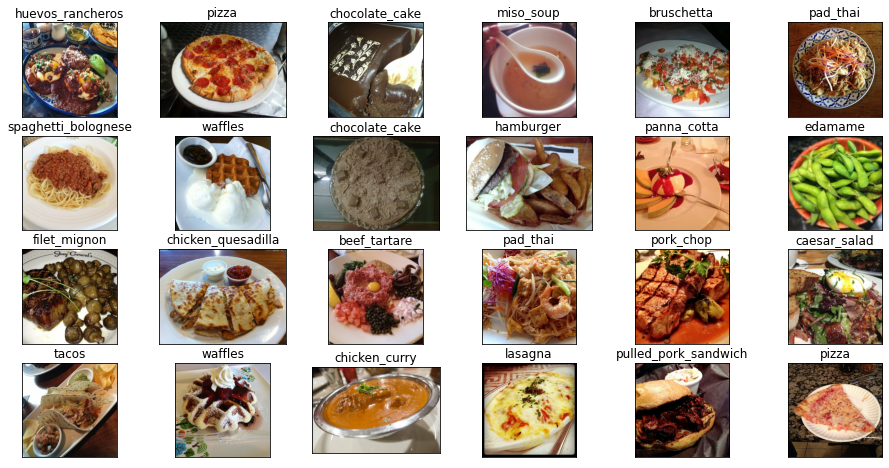

In [6]:
sample = [x for x in iter(train_ds.take(24))]
N = len(sample)
fig = plt.figure(figsize=(16, 8))
for j in range(len(sample)):
    ax = fig.add_subplot(4, 6, j+1)
    ax.imshow(sample[j][0])
    plt.xticks([])
    plt.yticks([])
    plt.title(class_names[sample[j][1]])
    plt.grid(False)
plt.show()

### Подготовим пайплайн.

In [7]:
INP_SIZE = 160
NUM_EPOCHS = 20
BATCH_SIZE = 32

def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

In [8]:
EXP_NAME = 'transfer'
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet',
)

base_model.trainable = False 

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(320, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(101, activation='softmax'),
])

9420800/9406464 [==============================] - 0s 0us/step


### Проведем подготовку к обучению.

In [9]:
LEARNING_RATE = 0.0005

optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 320)               409920    
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 101)               32421     
                                                                 
Total params: 2,700,325
Trainable params: 442,341
Non-tr

### Обучение модели.

In [11]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/20
2130/2130 [==============================] - 225s 98ms/step - loss: 2.8300 - accuracy: 0.3265 - val_loss: 2.0476 - val_accuracy: 0.4922
Epoch 2/20
2130/2130 [==============================] - 209s 98ms/step - loss: 2.2733 - accuracy: 0.4406 - val_loss: 1.9706 - val_accuracy: 0.5073
Epoch 3/20
2130/2130 [==============================] - 207s 96ms/step - loss: 2.1615 - accuracy: 0.4702 - val_loss: 1.9678 - val_accuracy: 0.5093
Epoch 4/20
2130/2130 [==============================] - 207s 97ms/step - loss: 2.1093 - accuracy: 0.4843 - val_loss: 1.9833 - val_accuracy: 0.5119
Epoch 5/20
2130/2130 [==============================] - 199s 93ms/step - loss: 2.0690 - accuracy: 0.4948 - val_loss: 2.0386 - val_accuracy: 0.5082
Epoch 6/20
2130/2130 [==============================] - 203s 95ms/step - loss: 2.0414 - accuracy: 0.5062 - val_loss: 2.0438 - val_accuracy: 0.5177
Epoch 7/20
2130/2130 [==============================] - 198s 92ms/step - loss: 2.0222 - accuracy: 0.5117 - val_loss: 2

### Произведем оценку качества модели.

In [12]:
%%time

model.evaluate(test_ds)

59/59 [==============================] - 18s 289ms/step - loss: 2.8081 - accuracy: 0.4889
CPU times: user 33.5 s, sys: 1.49 s, total: 34.9 s
Wall time: 18.2 s


[2.808081865310669, 0.4888771176338196]

### Проверим работу модели на произвольном изображении, например паэльи.

--2022-07-16 19:22:51--  https://pro-spain.net/wp-content/uploads/2016/02/paelya.jpg
Resolving pro-spain.net (pro-spain.net)... 45.130.41.136
Connecting to pro-spain.net (pro-spain.net)|45.130.41.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 598182 (584K) [image/jpeg]
Saving to: ‘paelya.jpg.2’

paelya.jpg.2        100%[===================>] 584.16K   493KB/s    in 1.2s    

2022-07-16 19:22:54 (493 KB/s) - ‘paelya.jpg.2’ saved [598182/598182]



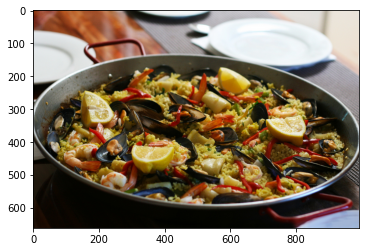

In [16]:
def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

if 1:
    !wget https://pro-spain.net/wp-content/uploads/2016/02/paelya.jpg

img = imageio.imread('paelya.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [18]:
pred = model(img[None, ...], training=False)

pred_label = int(pred.numpy()[0][0] > 0.5)
print('Prediction: {}'.format(ds_info.features['label'].int2str(pred_label)))

Prediction: apple_pie
